## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pmdarima as pm

# Exploration and data visualization

In [2]:
df = pd.read_csv("../output/data_cleaning/2_cleaned_data_45_countries.csv")
df = df.set_index(['year'])
df

,country,population,gdp,cement_co2,coal_co2,flaring_co2,gas_co2,land_use_change_co2,oil_co2,cumulative_co2_including_luc,co2_including_luc
year,,,,,,,,,,,
1928,Argentina,11139114.0,7.716888e+10,0.116,8.284,0.000,0.297,228.958,4.041,5108.347,241.697
1929,Argentina,11443159.0,8.069191e+10,0.174,8.321,0.000,0.458,229.748,4.177,5351.226,242.878
1930,Argentina,11726853.0,7.735969e+10,0.189,8.119,0.000,0.454,181.910,4.005,5545.904,194.678
1931,Argentina,11989069.0,7.199214e+10,0.265,6.947,0.000,0.564,150.371,5.067,5709.119,163.215
1932,Argentina,12228636.0,6.962483e+10,0.247,6.331,0.000,0.769,132.840,5.752,5855.059,145.940
...,...,...,...,...,...,...,...,...,...,...,...
2018,Vietnam,94914328.0,6.815014e+11,49.637,122.121,1.373,18.554,247.029,66.036,12087.070,504.751
2019,Vietnam,95776712.0,7.316531e+11,56.538,191.443,1.453,18.906,248.054,73.449,12676.914,589.843
2020,Vietnam,96648680.0,7.526296e+11,60.066,215.817,1.257,16.931,249.736,69.272,13289.992,613.079


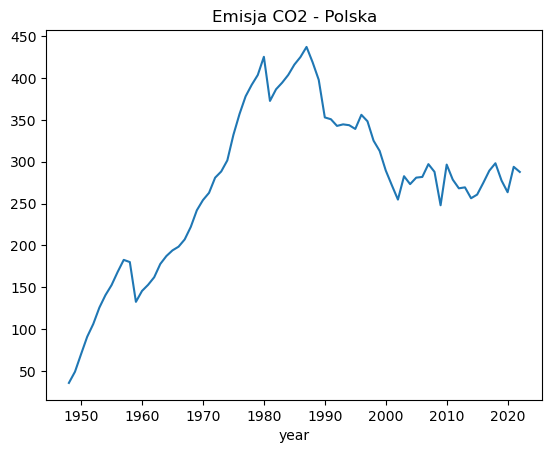

In [3]:
# Visualize the example data (eg. Poland)
df[df['country'] == 'Poland']['co2_including_luc'].plot(title='Emisja CO2 - Polska')
plt.show()

In [ ]:
#check stationarity if d = 1 is enough
# from statsmodels.tsa.stattools import adfuller

# def test_stationarity(series):
#     result = adfuller(series)
#     print('ADF Statistic:', result[0])
#     print('p-value:', result[1])
#     return result[1]  # p-value, im niższe, tym lepiej

# # Przykład: Sprawdzenie stacjonarności dla Polski
# poland_data = df[df['country'] == 'Poland']['co2_including_luc']
# p_value = test_stationarity(poland_data)
# if p_value > 0.05:
#     print("Dane nie są stacjonarne. Konieczne różnicowanie.")
# else:
#     print("Dane są stacjonarne.")

# df['co2_diff'] = df.groupby('country')['co2_including_luc'].diff()
# df = df.dropna(subset=['co2_diff'])

# poland_data = df[df['country'] == 'Poland']['co2_diff']
# p_value = test_stationarity(poland_data)
# if p_value > 0.05:
#     print("Dane nie są stacjonarne. Konieczne różnicowanie.")
# else:
#     print("Dane są stacjonarne.")

# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# # Autocorelation
# plot_acf(df[df['country'] == 'Poland']['co2_diff'].dropna())
# plot_pacf(df[df['country'] == 'Poland']['co2_diff'].dropna())
# plt.show()

In [4]:
class DataPreprocessorARIMAX:
    def __init__(self):
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()

    def preprocess_numerical_data_train(self, X_train, y_train):
        
        X_train_scaled = pd.DataFrame(
            self.scaler_X.fit_transform(X_train),
            columns=X_train.columns,
            index=X_train.index,
        )

        
        y_train_scaled = pd.Series(
            self.scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten(),
            index=y_train.index,
            name=y_train.name,
        )

        return X_train_scaled, y_train_scaled

    def preprocess_numerical_data_test(self, X_test, y_test):
        
        X_test_scaled = pd.DataFrame(
            self.scaler_X.transform(X_test),
            columns=X_test.columns,
            index=X_test.index,
        )

        
        y_test_scaled = pd.Series(
            self.scaler_y.transform(y_test.values.reshape(-1, 1)).flatten(),
            index=y_test.index,
            name=y_test.name,
        )

        return X_test_scaled, y_test_scaled

    def inverse_transform_y(self, y_scaled):
        if isinstance(y_scaled, pd.Series):
            y_scaled = y_scaled.to_frame()
        return self.scaler_y.inverse_transform(y_scaled).flatten()

In [5]:
preprocessor = DataPreprocessorARIMAX()

df_filtered = df[df['country'] == 'Poland'].drop(columns='country')

target_column = 'co2_including_luc'
X = df_filtered.drop(columns=[target_column])
y = df_filtered[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train_scaled, y_train_scaled = preprocessor.preprocess_numerical_data_train(X_train, y_train)
X_test_scaled, y_test_scaled = preprocessor.preprocess_numerical_data_test(X_test, y_test)

print(f'Rozmiar treningowego X: {X_train_scaled.shape}')
print(f'Rozmiar testowego X: {X_test_scaled.shape}')
print(f'Rozmiar treningowego y: {y_train_scaled.shape}')
print(f'Rozmiar testowego y: {y_test_scaled.shape}')

Rozmiar treningowego X: (60, 9)
Rozmiar testowego X: (15, 9)
Rozmiar treningowego y: (60,)
Rozmiar testowego y: (15,)


In [6]:
X_test_scaled

,population,gdp,cement_co2,coal_co2,flaring_co2,gas_co2,land_use_change_co2,oil_co2,cumulative_co2_including_luc
year,,,,,,,,,
2008,1.043744,2.986830,0.579739,-0.421547,1.823906,1.740850,-0.412074,1.664319,1.823193
2009,1.050895,3.223594,0.172604,-0.565124,1.338976,1.643587,-1.996094,1.701718,1.870120
2010,1.060179,3.465748,0.374432,-0.415816,1.763979,1.853928,-0.172180,1.852194,1.926231
2011,1.065363,3.794815,0.878130,-0.447912,2.131120,1.875391,-1.214365,1.833786,1.978943
2012,1.066471,3.884861,0.445332,-0.502569,2.261996,2.014677,-1.377421,1.672890,2.029696
2013,1.062384,3.935547,0.223496,-0.499117,2.668401,2.042467,-1.066160,1.447274,2.080668
2014,1.056763,4.164540,0.476650,-0.641674,2.599519,1.891094,-1.105421,1.432519,2.129179
2015,1.050423,4.436177,0.427063,-0.658679,2.630516,2.023263,-1.032431,1.598529,2.178513
2016,1.045779,4.627231,0.508838,-0.652986,2.497573,2.225018,-0.847009,1.997020,2.230480


In [7]:
# Build the model
model = pm.auto_arima(
    y = y_train_scaled, 
    X = X_train_scaled,
    start_p = 1,
    test = 'adf',
    start_q = 1,
    seasonal = False,
    trace = True
)
print(model.summary())
print(model.params)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-532.489, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-536.478, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-534.498, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-534.495, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-534.478, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.400 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   60
Model:                        SARIMAX   Log Likelihood                 278.239
Date:                Mon, 23 Sep 2024   AIC                           -536.478
Time:                        16:18:45   BIC                           -515.534
Sample:                             0   HQIC                          -528.285
                                 - 60                                       

In [8]:
# Prediction - test set
y_pred_scaled = model.predict(n_periods=len(X_test_scaled), X=X_test_scaled)
y_pred_scaled = y_pred_scaled.values.reshape(-1, 1)
y_pred = preprocessor.inverse_transform_y(y_pred_scaled)
y_test_inversed = preprocessor.inverse_transform_y(y_test_scaled)

print(y_pred)
print(y_test_inversed)

[287.60988743 247.20561894 295.78260628 277.70849438 267.68519725
 269.18236745 255.96329336 260.13940992 273.4611402  288.1629564
 296.8526918  275.68262384 261.64826418 290.68515138 284.92651932]
[287.913 248.021 296.561 278.601 268.243 269.395 256.397 260.743 274.659
 289.335 298.164 277.588 263.564 293.902 287.777]


/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


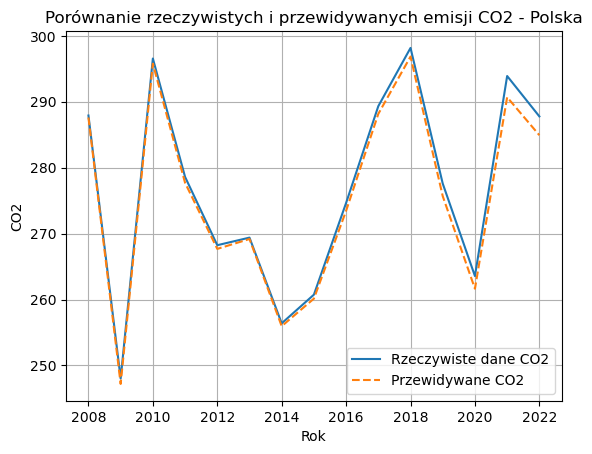

In [9]:
# Visualization - test set
plt.plot(y_test.index, y_test_inversed, label='Rzeczywiste dane CO2')
plt.plot(y_test.index, y_pred, label='Przewidywane CO2', linestyle='--')
plt.xlabel('Rok')
plt.ylabel('CO2')
plt.title('Porównanie rzeczywistych i przewidywanych emisji CO2 - Polska')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Prediction - train set
y_pred_train_scaled = model.predict(n_periods=len(X_train_scaled), X=X_train_scaled)
y_pred_train_scaled = y_pred_train_scaled.values.reshape(-1, 1)
y_train_pred = preprocessor.inverse_transform_y(y_pred_train_scaled)
y_train_inversed = preprocessor.inverse_transform_y(y_train_scaled)

print(y_train_pred)
print(y_train_inversed)

[ 36.31495184  49.40631526  70.29513596  90.92236375 106.2550726
 125.76180034 140.71389324 152.68178624 168.35814784 182.74927731
 180.27817716 132.65434521 145.70281828 153.01662603 162.12367229
 177.83871804 187.3271995  194.19414771 198.59705425 207.28152479
 222.12733084 241.98299052 254.17778268 262.81674618 280.79648283
 288.3515786  301.58550351 331.98683112 356.81116966 378.02094802
 391.75233963 403.5216785  425.10698    372.83140953 386.78633038
 394.61937516 403.59434389 415.73000208 424.81317087 436.92183066
 418.80722906 398.39913991 352.67065201 350.61163375 343.03553432
 344.63647395 343.0489695  339.13335923 355.41095439 348.17150158
 324.74240992 313.60627643 290.02549566 271.97106933 254.89198657
 282.95624275 272.31042187 280.96356157 282.19584267 296.98839322]
[ 35.947  49.312  70.337  90.99  106.293 125.813 140.752 152.681 168.406
 182.826 180.211 132.73  145.741 153.062 162.098 177.944 187.405 194.165
 198.575 207.186 222.121 242.045 254.186 262.866 280.944 288.3

/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


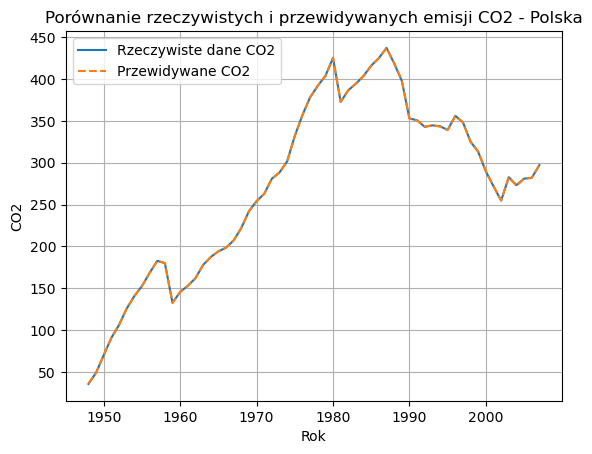

In [11]:
# Visualization - train set
plt.plot(y_train.index, y_train_inversed, label='Rzeczywiste dane CO2')
plt.plot(y_train.index, y_train_pred, label='Przewidywane CO2', linestyle='--')
plt.xlabel('Rok')
plt.ylabel('CO2')
plt.title('Porównanie rzeczywistych i przewidywanych emisji CO2 - Polska')
plt.legend()
plt.grid(True)
plt.show()